# Citibike 2019 Trip Data Exploration

In [1]:
# Loading libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Loading csv files and combining them into dataframe
%%time

data_files=['./data/201901-citibike-tripdata.csv',
            './data/201902-citibike-tripdata.csv',
            './data/201903-citibike-tripdata.csv',
            './data/201904-citibike-tripdata.csv',
            './data/201905-citibike-tripdata.csv',
            './data/201906-citibike-tripdata.csv',
            './data/201907-citibike-tripdata.csv',
            './data/201908-citibike-tripdata.csv',
            './data/201909-citibike-tripdata.csv',
            './data/201910-citibike-tripdata.csv',
            './data/201911-citibike-tripdata.csv',
            './data/201912-citibike-tripdata.csv']

dfs = [pd.read_csv(f) for f in data_files]

df = pd.concat(dfs,ignore_index=True)

print(df.shape)

(20551697, 15)
CPU times: user 1min 10s, sys: 22.3 s, total: 1min 33s
Wall time: 1min 44s


In [4]:
rides = df.copy()

In [5]:
rides.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id           float64
start station name          object
start station latitude     float64
start station longitude    float64
end station id             float64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object

In [6]:
rides.isnull().sum()

tripduration                 0
starttime                    0
stoptime                     0
start station id           180
start station name         180
start station latitude       0
start station longitude      0
end station id             180
end station name           180
end station latitude         0
end station longitude        0
bikeid                       0
usertype                     0
birth year                   0
gender                       0
dtype: int64

In [7]:
# Simple cleaning of the dataframe
rides['starttime'] = pd.to_datetime(rides['starttime'])
rides['stoptime'] = pd.to_datetime(rides['stoptime'])
rides.rename(columns={'start station id':'start_station_id', 'start station name':'start_station_name',\
                     'start station latitude':'start_station_lat', 'start station longitude':'start_station_long',\
                     'end station id':'end_station_id', 'end station name':'end_station_name',\
                     'end station latitude':'end_station_lat', 'end station longitude':'end_station_long'},\
             inplace=True)
rides.dropna(inplace=True)
rides['start_station_id'] = rides['start_station_id'].astype(int)
rides['end_station_id'] = rides['end_station_id'].astype(int)
rides['date'] = rides['starttime'].dt.strftime('%Y-%m-%d')
rides['date'] = pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.strftime('%Y-%m')

## Data Visualizations

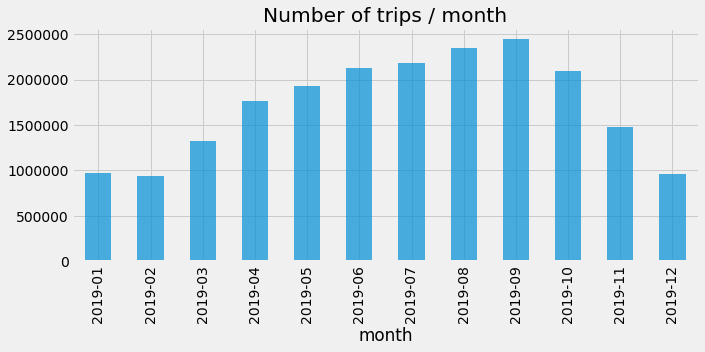

In [12]:
rides.groupby('month')['starttime'].count().plot(kind='bar',figsize=(10,4), title='Number of trips / month', alpha=0.7)

In [13]:
# Grouping trips by gender
genders = ['Unknown', 'Male', 'Female']
y_pos = [0, 1, 2]
trip_counts = rides.groupby('gender')['gender'].count()

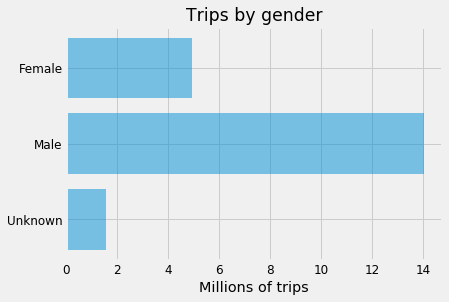

In [14]:
plt.rcParams.update({'font.size': 12})
plt.barh(y_pos, trip_counts / 1000000, align = 'center', alpha=0.5)
plt.yticks(y_pos, genders)
plt.xlabel('Millions of trips')
plt.title('Trips by gender')
plt.show()

In [15]:
# Collect all trips shorter than one hour
duration_mins = rides.loc[(rides.tripduration / 60 < 60)][['tripduration']]
duration_mins = duration_mins / 60

Text(0, 0.5, 'Trip counts')

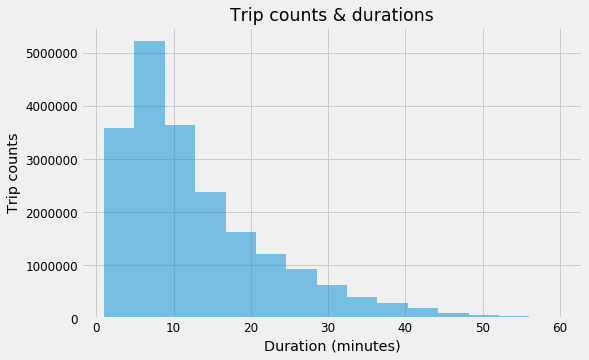

In [16]:
# Plot the distribution of trip durations
plt.rcParams.update({'font.size': 12})
duration_mins.hist(figsize = (8,5), bins = 15, alpha=0.5)
plt.tick_params(axis = 'both', which = 'major')
plt.title('Trip counts & durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Trip counts')

In [17]:
# Calculate trip counts per hour on weekdays and weekends
rides_sub = rides.loc[:, ['tripduration', 'starttime']]
rides_sub.index = rides_sub['starttime']
weekdays = rides_sub[rides_sub.index.weekday < 5]
weekends = rides_sub[rides_sub.index.weekday > 4]
weekday_ridesPerHr = weekdays.groupby(weekdays.index.hour).size()
weekend_ridesPerHr = weekends.groupby(weekends.index.hour).size()

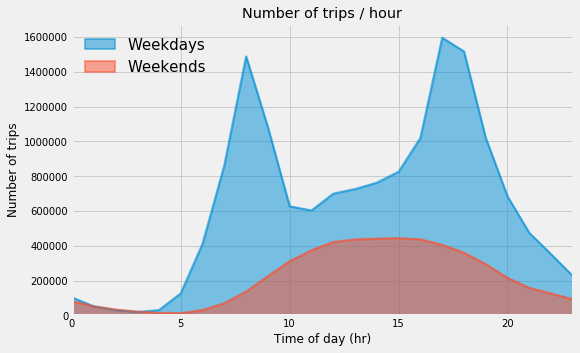

In [18]:
plt.rcParams.update({'font.size': 10, 'legend.fontsize': 15})
weekday_ridesPerHr.plot(kind = 'area', stacked = False, figsize = (8, 5), linewidth = 2, label='Weekdays')
weekend_ridesPerHr.plot(kind = 'area', stacked = False, linewidth = 2, label='Weekends')
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax = plt.gca()
plt.title('Number of trips / hour')
plt.xlabel('Time of day (hr)')
plt.ylabel('Number of trips')
legend = ax.legend(loc='upper left', frameon = False)

## Creating maps for trips + duration by start station

In [23]:
start_station = rides.iloc[:,[3, 4, 5, 6]]
start_station.index = start_station['start_station_id']
start_station['trip_count'] = rides.groupby('start_station_id')['start_station_id'].count()
start_station['mean_duration'] = rides.groupby('start_station_id')['tripduration'].mean()
start_station = start_station.drop_duplicates()
start_station.head()

,start_station_id,start_station_name,start_station_lat,start_station_long,trip_count,mean_duration
start_station_id,,,,,,
3160,3160,Central Park West & W 76 St,40.778968,-73.973747,35325,1422.521868
519,519,Pershing Square North,40.751873,-73.977706,156575,844.074986
3171,3171,Amsterdam Ave & W 82 St,40.785247,-73.976673,32186,880.637265
504,504,1 Ave & E 16 St,40.732219,-73.981656,82553,749.692682
229,229,Great Jones St,40.727434,-73.993790,76523,729.116632


In [25]:
# Create map based on start station mean trip durations
import folium
from matplotlib.colors import Normalize, rgb2hex
import matplotlib.cm as cm

norm = Normalize(start_station['trip_count'].min(), start_station['trip_count'].max())
# Get dark tileset from CartoBD (https://cartodb.com/basemaps)
tileset = r'http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'

start_station_map = folium.Map(location = [40.74, -73.97], width = 600, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

for index, row in start_station.iterrows():
    color = rgb2hex(cm.YlOrRd(norm(row['trip_count'])))
    folium.CircleMarker(location = [row['start_station_lat'],
                                                row['start_station_long']],
                                    popup = row['start_station_name'],
                                    radius = row['mean_duration'] / 1000,
                                    fill_color = '#00FFFF', line_color = '#00FFFF').add_to(start_station_map)
    
start_station_map.save(outfile = 'start_station_map.html')

del start_station_map

In [26]:
from IPython.display import IFrame
IFrame('start_station_map.html', width = 600, height = 600)

In [27]:
# Creating same map but focused on trip counts
start_station_map2 = folium.Map(location = [40.74, -73.97], width = 600, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

for index, row in start_station.iterrows():
    color = rgb2hex(cm.YlOrRd(norm(row['trip_count'])))
    folium.CircleMarker(location = [row['start_station_lat'],
                                                row['start_station_long']],
                                    popup = row['start_station_name'],
                                    radius = row['trip_count'] / 10000,
                                    fill_color = '#00FFFF', line_color = '#00FFFF').add_to(start_station_map2)
    
start_station_map2.save(outfile = 'start_station_map2.html')

del start_station_map2

In [28]:
from IPython.display import IFrame
IFrame('start_station_map2.html', width = 600, height = 600)

In [29]:
end_station = rides.iloc[:, [7, 8, 9, 10]]
end_station.index = end_station['end_station_id']
end_station = end_station.drop_duplicates()
end_station['trip_count'] = rides.groupby('end_station_id')['end_station_id'].count()
end_station['mean_duration'] = rides.groupby('end_station_id')['tripduration'].mean()
end_station.head()

,end_station_id,end_station_name,end_station_lat,end_station_long,trip_count,mean_duration
end_station_id,,,,,,
3283,3283,W 89 St & Columbus Ave,40.788221,-73.970416,23308,973.099451
518,518,E 39 St & 2 Ave,40.747804,-73.973442,61256,898.015900
3154,3154,E 77 St & 3 Ave,40.773142,-73.958562,18724,688.203055
3709,3709,W 15 St & 6 Ave,40.738046,-73.996430,28946,717.614178
503,503,E 20 St & Park Ave,40.738274,-73.987520,55951,682.093510


In [31]:
# Creating map for end stations mean trip count for comparison purposes
tileset = r'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
end_station_map = folium.Map(location = [40.74, -73.97], width = 600, height = 600,
                               tiles = tileset,
                               attr = '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
                               zoom_start = 12)

for index, row in end_station.iterrows():
    color = rgb2hex(cm.YlOrRd(norm(row['trip_count'])))
    folium.CircleMarker(location = [row['end_station_lat'],
                                                row['end_station_long']],
                                    popup = row['end_station_name'],
                                    radius = row['trip_count'] / 10000,
                                    fill_color = '#00FFFF', line_color = '#00FFFF').add_to(end_station_map)
    
end_station_map.save(outfile = 'end_station_map.html')

del end_station_map

IFrame('end_station_map.html', width = 600, height = 600)

In [32]:
# Creating new dataframe column for 'day_of_week' and datehour'
rides['day_of_week'] = rides['starttime'].dt.day_name()
rides['datehour'] = rides['starttime'].dt.hour

In [34]:
weekday_hourly = rides.groupby(['day_of_week','datehour']).size().reset_index(name='total_rides')

Text(52.73866319444444, 0.5, 'Trip count')

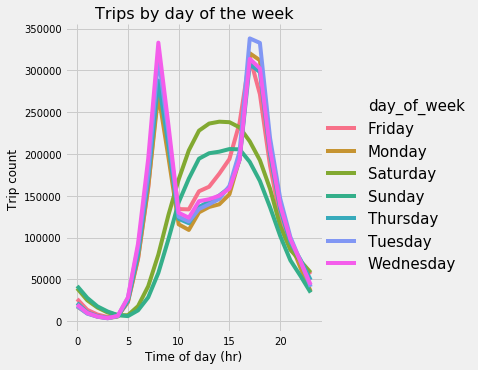

In [35]:
sns.relplot(x="datehour", y="total_rides", data=weekday_hourly, hue="day_of_week", kind="line")
plt.title('Trips by day of the week', fontsize=16)
plt.xlabel('Time of day (hr)')
plt.ylabel('Trip count')